# Optimization for Data Science 2024 Homework 1

**Students:**

*Alberto Calabrese* - Student ID: 2103405

*Greta d'Amore Grelli* - Student ID: 2122424

*Eleonora Mesaglio* - Student ID: 2103402

*Marlon Helbing* - Student ID: 2106578

## 1. Generating the dataset

## Cost function 

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import time
from sklearn.model_selection import train_test_split
# Set a seed for deterministic outputs
SEED = 37
np.random.seed(seed = SEED)

In [4]:
NUM_SAMPLES = 1000
NUM_FEATURES = 1000
NUM_LABELS = 50
NUM_EXAMPLES = 1000

# A MATRIX
# Generate a 1000x1000 matrix with random samples from a standard normal distribution
# This is our data matrix, which contains 1000 samples (rows) with 1000 features each (columns)
data_matrix = np.random.normal(0, 1, size = (NUM_SAMPLES, NUM_FEATURES))
A = data_matrix 
# 'A' contains random values drawn from N(0,1)
print("A shape: ", A.shape)

# X MATRIX
# This is our weight matrix that we initialize like this ; these weights we want to learn
# it has 1000 features (rows) with 50 labels each (columns)
weight_matrix = np.random.normal(0, 1, size = (NUM_FEATURES, NUM_LABELS))
X = weight_matrix
# 'X' contains random values drawn from N(0,1)
print("X shape: ", X.shape)

# E MATRIX
# This matrix is used to help generating our supervised gold labels 
# It is of size 1000 training examples (rows) and their labels (columns)
generative_matrix = np.random.normal(0, 1, size = (NUM_EXAMPLES, NUM_LABELS))
E = generative_matrix
# 'E' contains random values drawn from N(0,1)
print("E shape: ", E.shape)

# LABEL VECTOR
# Create a vector with numbers from 1 to 50
label_vector = np.arange(1, 51)

# Now calculate AX+E to generate labels for the 1000 training examples (such that we have a supervised learning set) 

result_matrix = A @ X + E

print("AX+E shape: ", result_matrix.shape)

A shape:  (1000, 1000)
X shape:  (1000, 50)
E shape:  (1000, 50)
AX+E shape:  (1000, 50)


## 2. MAX INDEX AS CLASS LABEL

In [5]:
# We find our labels by considering the max index in the row as the class label
# Find the column indices of maximum values for each row
labels = np.argmax(result_matrix, axis=1)
print("Labels shape: ", labels.shape)

# 'labels' now contains the column indices of maximum values for each row

Labels shape:  (1000,)


In [6]:
m = NUM_SAMPLES # samples
d = NUM_FEATURES # features
k = NUM_LABELS   # labels

## 3. Cost function 

In [7]:
def cost_function_dummy(X,A,labels):
    # Basic cost function using double sum ; no matrix notation
    sum_1 = 0
  
    for sample_idx in range(m):

        # Take the column at index of the label of the current sample
        x_bi = X[:, labels[sample_idx]]
        x_bi = -1 * x_bi
        a_i = A[sample_idx, :]
        sum_1 += (x_bi @ a_i) # automatically calculates (1,1000) x (1000,1)
    sum_2 = 0
    for sample_idx in range(m):
        current = 0 # so we have the correct start value
        for label_idx in range(k):
            current += np.exp((X[:,label_idx]) @ A[sample_idx,:])
        sum_2 += np.log(current)

    return sum_1 + sum_2

In [8]:
def cost_function_1(X,A,labels):

    # APPROACH 1 
    # Seperate the sum over the samples in two terms
    # Vectorize both independently, then take the sum over m for both and add together


    X_b = np.zeros((m,d)) # We wrote it as (X_b)^t
    # Iterate over all labels and notice that we have a label for each sample, thus we can use idx directly
    for idx,label in enumerate(labels):
        X_b[idx,:] = X[:,label]

    # Now calculate the trace 
    term_1 = -1 * (np.trace(X_b @ A.T))


    vec_ = np.zeros((m,1))
    for sample_idx in range(m):
        vec_[sample_idx] = np.log((np.exp(X.T @ A[sample_idx,:])).T @ np.ones((k,1)))

    term_2 = vec_.T @ np.ones((m,1))






    return term_1 + term_2

In [9]:
# Preparation for cost function 2 & 3

# Encoding I_b
# Since The labels stay the same over all iterations of our gradient descent algorithms, we will encode it before using the cost function,
# simply because else it would be more expensive

I_b = np.zeros((k,m))
# Iterate over all the labels 
for idx,label in enumerate(labels):
    indicator = np.zeros((k)) # Set to all 0's 
    indicator[label] = 1 # Set 1 at the index of the label (since we have 0 to 49, we can directly use label instead of label+1)
    I_b[:,idx] = indicator


In [10]:
def cost_function_2(X,A,labels):

    # APPROACH 2 : Write formula 'as one' in terms of the sum over m
    # Thus, change the approach for the first term, utilizing matrix X directly and taking the diagonal

    # X : d x k
    # A : m x d
    # AX : m x k
    # matrix I_b (indicator) encodes the labels b_i for each sample, thus it has form k x m (each column is indicator, where only at index b_i (label of i) is 1, else 0)
    # AX @  I_b
    # from this final matrix, we take just the diagonal entries 
    # we get a vector of size (m,)

    term_1 = -1 * (np.diag((A @ X) @ I_b))

    vec_ = np.zeros((m,1))
    for sample_idx in range(m):
        vec_[sample_idx] = np.log((np.exp(X.T @ A[sample_idx,:])).T @ np.ones((k,1)))

    term_2 = vec_.T

    final = (term_1 + term_2) @ np.ones((m,1))


    return final  

    

    

In [11]:
def cost_function_3(X,A,labels):
    # APPROACH 3 :
    # Similar to cost_function_2, with the difference of changing term_2 such that we can use matrix A directly



    # X : d x k
    # A : m x d
    # AX : m x k
    # matrix I_b (indicator) encodes the labels b_i for each sample, thus it has form k x m (each column is indicator, where only at index b_i (label of i) is 1, else 0)
    # AX @  I_b
    # from this final matrix, we take just the diagonal entries 
    # we get a vector of size (m,)

    term_1 = -1 * (np.diag((A @ X) @ I_b))
    
    term_2 = np.exp(A @ X) @ np.ones((k,1))



    final = (term_1 + (np.log(term_2)).flatten()) @ np.ones((m,1))


    return final  

In [13]:
# Define Gradient descent variables
EPSILON = 1e-6
ITERATIONS = 1000
LR = 0.001


In [14]:
# Plotting functions
def plotting(times,losses,gradient_norms):
    # Plotting loss vs time
    plt.figure(figsize=(10, 6))
    plt.plot(times, losses)
    plt.xlabel('CPU time (seconds)')
    plt.ylabel('Objective function')
    plt.title('Objective function vs CPU time - Gradient Descent')
    plt.yscale("log")
    plt.show()

    # Plotting gradient norm across iterations
    plt.figure(figsize=(10, 6))
    plt.plot(gradient_norms, label = 'Gradient Norm')
    plt.xlabel('Iteration')
    plt.ylabel('Gradient Norm')
    plt.title('Gradient Norm across Iterations - Gradient Descent')
    plt.yscale("log")
    plt.show()


## 4.Partial Gradient
We define as a block a single column in the parameter matrix $X$. Thus, one block defines all features for a single class. As this is a column vector in the matrix $X$, our partial gradient is now only dependent on $c$.

Then, our partial derivatives with respect with one block have the following form

\begin{equation}
\frac{\partial f(X)}{\partial X_{c}} = - A^{T} \cdot (I_c - Q_c) = A^{T} \cdot (Q_c - I_c)
\end{equation}


where 

$A$ has shape $m \times d$, it is our given matrix A;
\
$I_c$ has shape $m \times 1$, it is the indicator vector containing $1$'s only at the positions where the label of the current sample $i$ is $c$ and $0$'s everywhere else;
$$
I_c=\begin{cases}
			1 \quad & \text{if $label_{i} = c $}\\
            0 \quad & \text{otherwise}
		 \end{cases}
$$
\
$Q_c$ has shape $m \times 1$, it is the vector calculating the exponential expression $\dfrac{\exp(x_{c}^{T}a_{i})}{\sum_{c' = 1}^{k} \exp(x_{c'}^{T}a_{i}) }$ for each sample $i$.

Thus, our result will be of form $d \times 1$.

Note that the calculations needed for $I_c$ and $Q_c$ only depend on $c$ and $i$. However, as we know all the samples $i$, we construct the vectors $I_c$ and $Q_c$ which are then only dependent on $c$.

In [15]:
# Gradient preparations

# Calculating the label encoder I_c

# We calculate once the encoding for all classes (I)

# I is of size (m,k)

I = np.zeros((m,k))
for label_idx in range(k):

    I[:,label_idx] = np.eye(k)[labels][:, label_idx]






In [16]:
def partial_gradient(X,A,labels,c):
    # We need X as parameter so it changes value across diff gradients

    # We define the partial gradient
    
    # Get the right indicator by selecting the column of the right class

    I_c = I[:,c]

    # Calculating vector Q for class c
    # use flatten to push it into (1000,)
    Q_c = np.exp(A @ X[:, c]) / ((np.exp(A @ X) @ np.ones((k,1))).flatten())


    return A.T @ (Q_c - I_c)

## 5. Full gradient

In [17]:
def full_gradient_final(X,A,labels):

    return (-1 * A.T) @ (I - ((np.exp(A @ X)) / (np.exp(A @ X) @ np.ones((k,1)))))

    

In [18]:
def gradient_descent_final(X,A,labels,lr, cost_function, iterations):

    gradient_norms = []
    X_values = []
    times = []
    start_time = time.time()
    for i in range(iterations):

        # Add values of X for to plot loss out of gradient calculation function (for better time efficiency in calculating the gradient)
        X_values.append(X)
        # Calculate gradient
        grad = full_gradient_final(X,A,labels)
        # Get the gradient norm
        norm = np.linalg.norm(grad)
        # Check the stopping criterium
        if norm < EPSILON:
            break
        # Add current gradient norm to list
        gradient_norms.append(norm)
        # Gradient step
        X = X - lr * grad
        # Add times
        times.append(time.time() - start_time)

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")


    return X_values, gradient_norms, times



## Searching for the most efficient Cost Function using full gradient descent

Execution time: 8.092159032821655 seconds
Execution time: 8.643745183944702 seconds
Execution time: 7.154309988021851 seconds
Execution time: 10.010052919387817 seconds


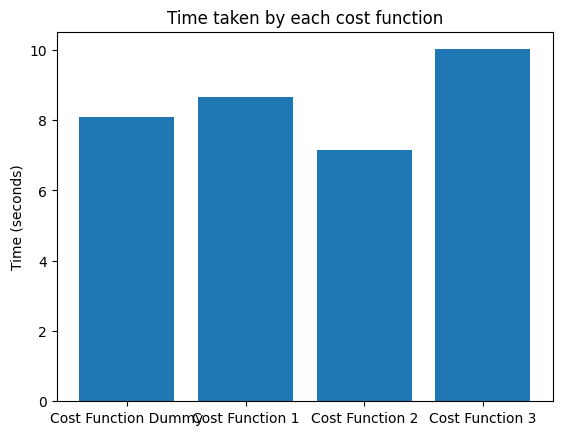

In [501]:
# Searching for the best cost function in terms of durational cost ; using the given partial derivative

cost_functions = [cost_function_dummy, cost_function_1, cost_function_2, cost_function_3]
times = []
for cost_func in cost_functions:
    X_0 = X.copy() # Reset to old matrix ; use copy to make a deep copy, such that changes in X_0 don't affect X
    start_time = time.time()
    _,_,_ = gradient_descent_final(X_0,A,labels,LR,cost_func,iterations=1000)  
    end_time = time.time()
    duration = end_time - start_time
    times.append(duration)

plt.bar(['Cost Function Dummy', 'Cost Function 1', 'Cost Function 2', 'Cost Function 3'], times)
plt.ylabel('Time (seconds)')
plt.title('Time taken by each cost function')
plt.show()


## 6. Gradient Descent Algorithm

Execution time: 9.468322038650513 seconds


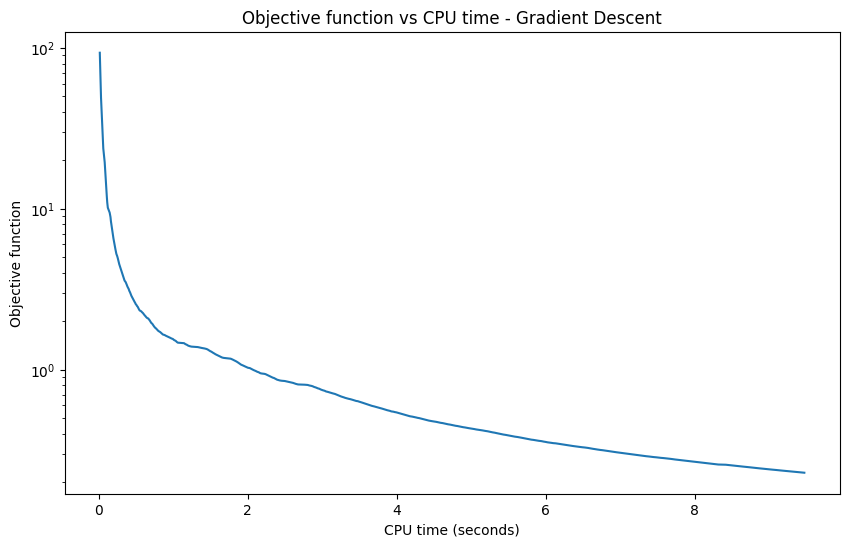

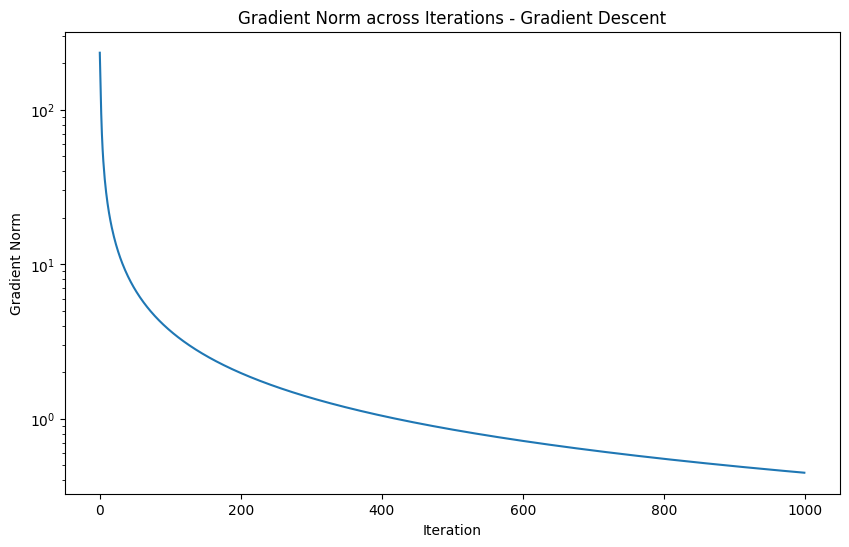

In [19]:
X_values, gradient_norms_GD, times_GD = gradient_descent_final(X,A,labels, lr= LR, cost_function = cost_function_3,  iterations= ITERATIONS)


losses_GD = [cost_function_3(X_val, A, labels) for X_val in X_values]

plotting(times_GD,losses_GD,gradient_norms_GD)

## 7. BCGD Randomized Rule

In [20]:
# Generate the list of random choices of classes beforehand 
random_choices = []
for i in range(ITERATIONS):
    random_choices.append(random.randint(0,k-1)) 

In [154]:
def BCGD_randomized(X,A,labels,lr, cost_function, iterations = 500):

    # Do a copy of X so we don't change each time we run the program new
    X_copy = X.copy()

    gradient_norms = []
    X_values = []
    times = []
    start_time = time.time()
    for i in range(iterations): 
        # Add values of X for to plot loss out of gradient calculation function (for better time efficiency in calculating the gradient)
        # why do we have to use np.copy again ? else constant value ???
        X_values.append(np.copy(X_copy))
        # Generate random c
        print(random_choices[i])
        curr_c = random_choices[i] #random.randint(0,k-1)
        # Calculate gradient
        grad = partial_gradient(X_copy,A,labels,curr_c) 
        # Get the gradient norm (of just the current block)
        norm = np.linalg.norm(grad)
        # Check the stopping criterium
        # Not added here, because we can always only calc norm of 
        # current partial gradient : better just do via iterations ?
  
        # Add current gradient norm to list
        gradient_norms.append(norm)
        # Gradient step
        X_copy[:, curr_c] = X_copy[:, curr_c] - lr * partial_gradient(X_copy,A,labels,curr_c) 
        # Add times
        times.append(time.time() - start_time)

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")


    return X_values, gradient_norms, times

    

Note that in the BCGD plot it plots the gradient norm of just the single blocks, which is why these go quicker to 0. in BCGD GS it plots the norm of the whole gradient!

Execution time: 7.150253057479858 seconds


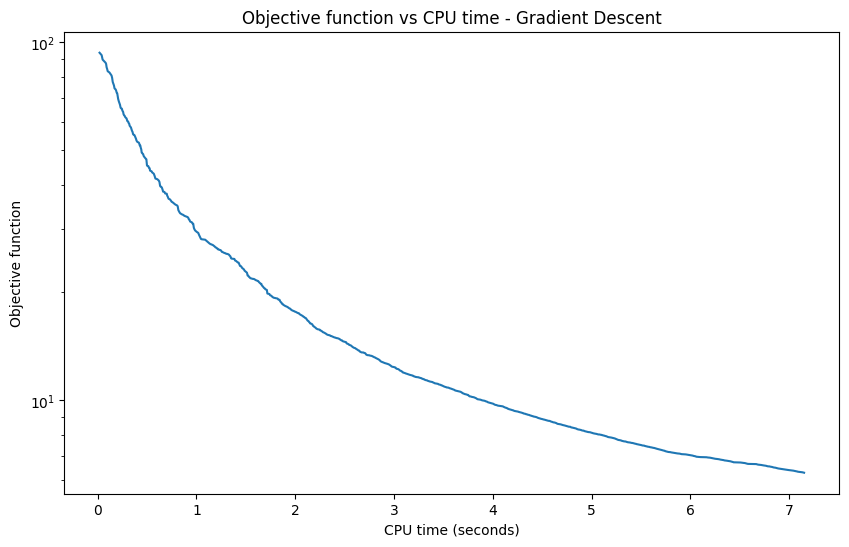

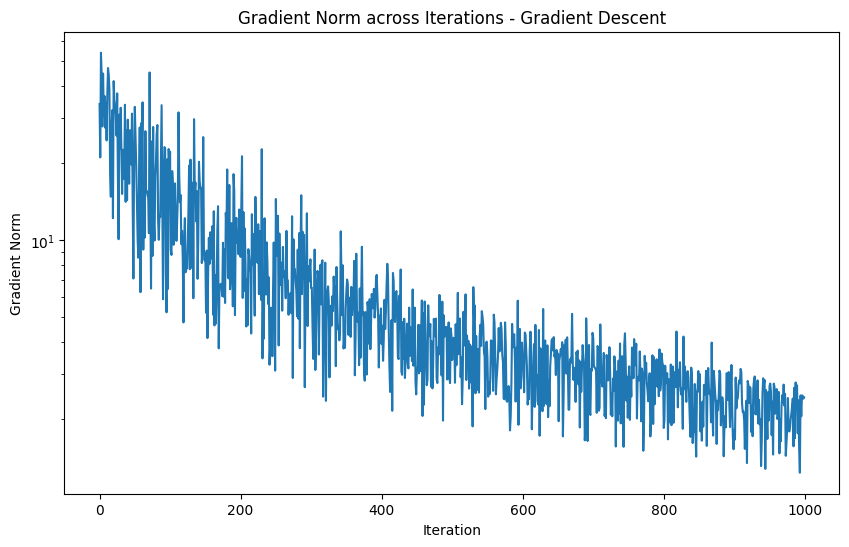

In [22]:
X_values, gradient_norms_BCGD, times_BCGD = BCGD_randomized(X,A,labels, LR, cost_function= cost_function_3, iterations= ITERATIONS)
losses_BCGD = [cost_function_3(X_val, A, labels) for X_val in X_values]

plotting(times_BCGD, losses_BCGD, gradient_norms_BCGD)

## 8. BCGD Gauss-Southwell Algorithm

In [23]:
def Gauss_Southwell_final(X,A, labels,lr, cost_function, iterations=20):


    # Calculate all partial gradients once, then just update on the one with biggest norm
    # Then, recalculate the norm of the just updated one and see if there is now a bigger one, then choose the bigger one

    # Start off with a copy of X
    X_copy = X.copy()

    gradient_norms = []
    X_values = []
    times = []
    start_time = time.time()

    # Calculate the full gradient once
    grad = full_gradient_final(X_copy,A,labels)

    # Calculate the norms 
    norms = np.linalg.norm(grad, axis=0)

    # Initialize a random column index as the max norm
    max_norm_class_index = 0



    for it in range(iterations): # iterations
        # In each iteration, check if there is a new maximal norm : Choose the biggest one for updating


        # Add values of X for to plot loss out of gradient calculation function (for better time efficiency in calculating the gradient)
        # why do we have to use np.copy again ? else constant value ???
        X_values.append(np.copy(X_copy))
        

        # In the first iteration, we already calculated gradients for all blocks, so we do the updating only starting
        # at the second iteration
        if it > 0:
            # Recalculate the gradient of the block gradient we updated
            grad[:, max_norm_class_index] = partial_gradient(X_copy,A,labels,c=max_norm_class_index)
            # Recalculate the norm of the block gradient we updated
            norms[max_norm_class_index] = np.linalg.norm(grad[:, max_norm_class_index])

        # Get sum of norms
        sum_norms = np.sum(norms)

        # Check the stopping criterium
        if sum_norms < EPSILON:
            break
        # Get the index of the column with the largest norm in the current iteration
        max_norm_class_index = np.argmax(norms)
 
        # Select the column with the largest norm
        max_norm_partial_grad = grad[:, max_norm_class_index]

        # Add gradient norm (of complete gradient)
        gradient_norms.append(sum_norms)
        # Gradient step
        X_copy[:, max_norm_class_index] = X_copy[:, max_norm_class_index] - lr * max_norm_partial_grad

        # Add times
        times.append(time.time() - start_time)

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")


    return X_values, gradient_norms, times



Execution time: 5.160094261169434 seconds


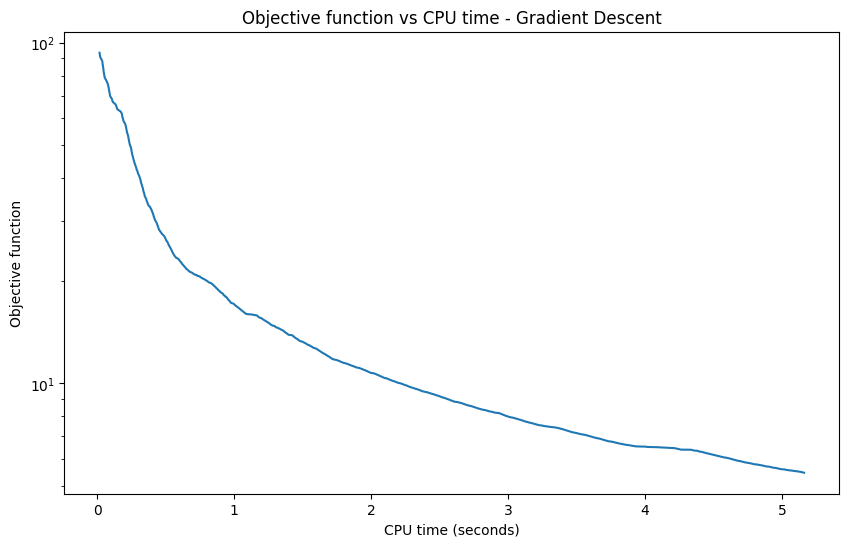

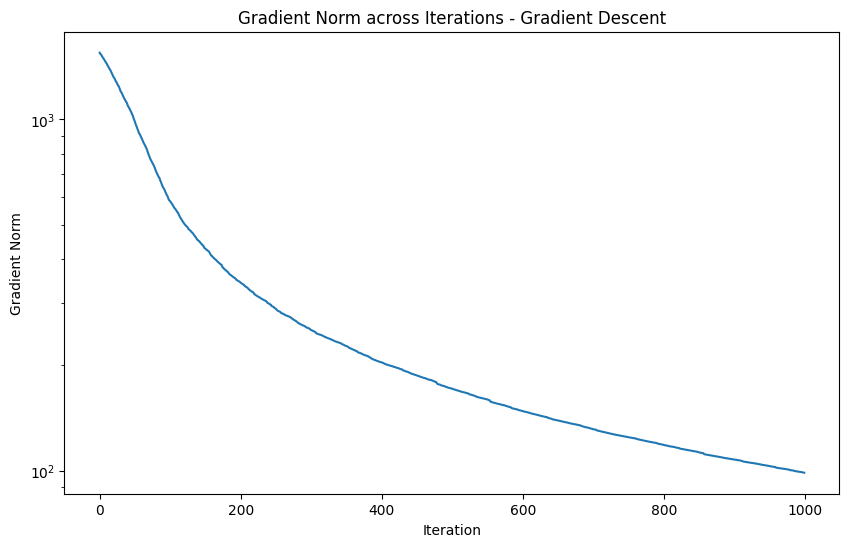

In [24]:
# Lest's see how it performs
X_values, gradient_norms_BCGD_GS, times_BCGD_GS = Gauss_Southwell_final(X,A,labels,LR, cost_function= cost_function_3,iterations= ITERATIONS)
losses_BCGD_GS = [cost_function_3(X_val, A, labels) for X_val in X_values]

plotting(times_BCGD_GS, losses_BCGD_GS, gradient_norms_BCGD_GS)

## Comparison between the models

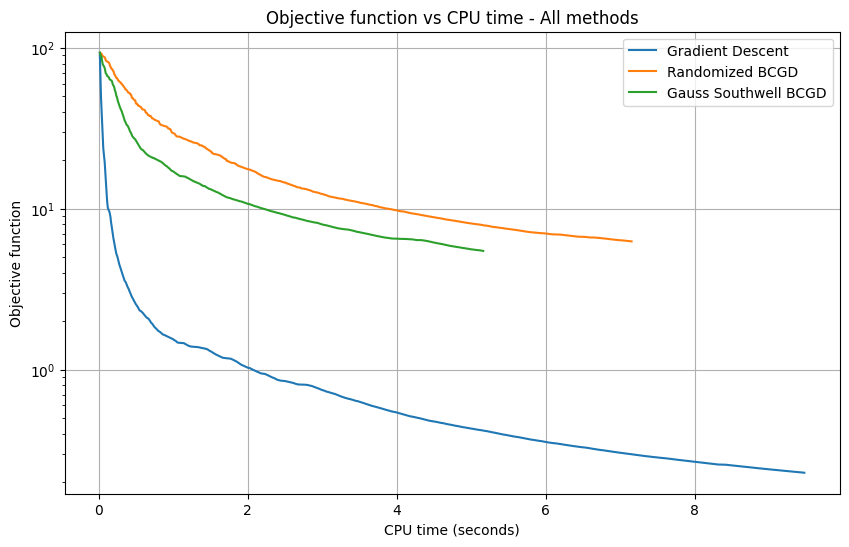

In [25]:
# Graph comparison of all three methods
plt.figure(figsize=(10, 6))
plt.plot(times_GD, losses_GD, label = 'Gradient Descent')
plt.plot(times_BCGD, losses_BCGD, label = 'Randomized BCGD')
plt.plot(times_BCGD_GS, losses_BCGD_GS, label = 'Gauss Southwell BCGD')
plt.xlabel('CPU time (seconds)')
plt.ylabel('Objective function')
plt.title('Objective function vs CPU time - All methods')
plt.grid(True)
plt.yscale("log")
plt.legend()
plt.show()

## 9. Real Dataset

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 

Modeling wine preferences by data mining from physicochemical properties.

In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

Available at: [@Elsevier] http://dx.doi.org/10.1016/j.dss.2009.05.016
            [Pre-press (pdf)] http://www3.dsi.uminho.pt/pcortez/winequality09.pdf
            [bib] http://www3.dsi.uminho.pt/pcortez/dss09.bib

1. Title: Wine Quality 

2. Sources
   
   Created by: Paulo Cortez (Univ. Minho), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis (CVRVV) @ 2009

 
3. Relevant Information:

   The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine.
   For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009].
   Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables 
   are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

   These datasets can be viewed as classification or regression tasks.
   The classes are ordered and not balanced (e.g. there are munch more normal wines than
   excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent
   or poor wines. Also, we are not sure if all input variables are relevant. So
   it could be interesting to test feature selection methods. 

4. Number of Instances: red wine - 1599; white wine - 4898. 

5. Number of Attributes: 11 + output attribute
  
   Note: several of the attributes may be correlated, thus it makes sense to apply some sort of feature selection.

6. Attribute information:

   Input variables (based on physicochemical tests):

      1 - fixed acidity
      
      2 - volatile acidity
      
      3 - citric acid
      
      4 - residual sugar
      
      5 - chlorides
      
      6 - free sulfur dioxide
      
      7 - total sulfur dioxide
      
      8 - density
      
      9 - pH
      
      10 - sulphates
      
      11 - alcohol
   
   Output variable (based on sensory data): 
   
      12 - quality (score between 0 and 10)



## Import, Exploration and Preparation

In [78]:
from sklearn.preprocessing import StandardScaler
# Adjust the path to the location of the dataset on your machine -----------------
data_red_wine = pd.read_csv('/Users/marlon/VS-Code-Projects/OptimizationNEW/HW1/wine+quality/winequality-red.csv', sep=';')
data_white_wine = pd.read_csv('/Users/marlon/VS-Code-Projects/OptimizationNEW/HW1/wine+quality/winequality-white.csv', sep=';')

# Let us define the labels from the dataset
labels_red = np.array(data_red_wine['quality'])
labels_white = np.array(data_white_wine['quality'])

# Let us see how many unique labels we have in both datasets
number_labels_red = np.unique(labels_red)
number_labels_white = np.unique(labels_white)

# Print the number of unique labels
print(number_labels_red)
print(number_labels_white)



# Let us work on the red wine dataset


labels = np.array(data_red_wine['quality'])

# Set labels so they start from 0 , since our smallest label is 3 and they go up in 1-steps , just subtract 3
labels = labels - 3



# Drop the quality column
data_red_wine.drop('quality', axis=1, inplace=True)

# Scale the data
scaler = StandardScaler()
# Fit and transform the data
data_red_wine = pd.DataFrame(scaler.fit_transform(data_red_wine), columns=data_red_wine.columns)

# Convert the data to a numpy array
A = np.array(data_red_wine)

NUM_SAMPLES = data_red_wine.shape[0]
NUM_FEATURES = data_red_wine.shape[1]
NUM_LABELS = len(number_labels_red)

m = NUM_SAMPLES # samples
d = NUM_FEATURES # features
k = NUM_LABELS   # labels






[3 4 5 6 7 8]
[3 4 5 6 7 8 9]


In [135]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
optical_recognition_of_handwritten_digits = fetch_ucirepo(id=80) 
  
# data (as pandas dataframes) 
X = optical_recognition_of_handwritten_digits.data.features 
y = optical_recognition_of_handwritten_digits.data.targets 


NUM_SAMPLES_ALL = X.shape[0]
NUM_FEATURES = X.shape[1]
NUM_LABELS = len(np.unique(y))

d = NUM_FEATURES
k = NUM_LABELS 

# Scale the data
scaler = StandardScaler()
# Fit and transform the data
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

A = np.array(X)
labels = np.array(y)


A_train, A_test, labels_train, labels_test = train_test_split(A, labels, test_size=0.2, random_state=42)







  


## Initiate Weight Matrix

In [131]:
weight_matrix = np.random.normal(0, 1, size = (NUM_FEATURES, NUM_LABELS))
X = weight_matrix

print(X.shape)

(64, 10)


## Gradient Descent

In [132]:
# Training Phase
m = A_train.shape[0]


In [133]:
# Preparations
# Calculating the label encoder I_c
# We calculate once the encoding for all classes (I)
# I is of size (m,k)

I = np.zeros((m,k))
for label_idx in range(k):

    I[:,label_idx] = np.eye(k)[labels_train.flatten()][:, label_idx]


# Preparation for cost function 2 & 3

# Encoding I_b
# Since The labels stay the same over all iterations of our gradient descent algorithms, we will encode it before using the cost function,
# simply because else it would be more expensive

I_b = np.zeros((k,m))
# Iterate over all the labels 
for idx,label in enumerate(labels_train):
    indicator = np.zeros((k)) # Set to all 0's 
    indicator[label] = 1 # Set 1 at the index of the label (since we have 0 to 49, we can directly use label instead of label+1)
    I_b[:,idx] = indicator




## GD

Execution time: 41.92232608795166 seconds


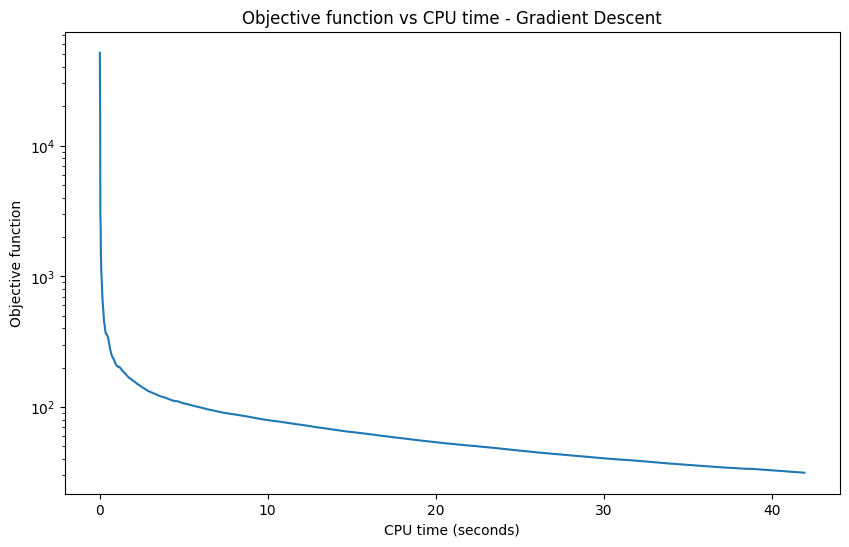

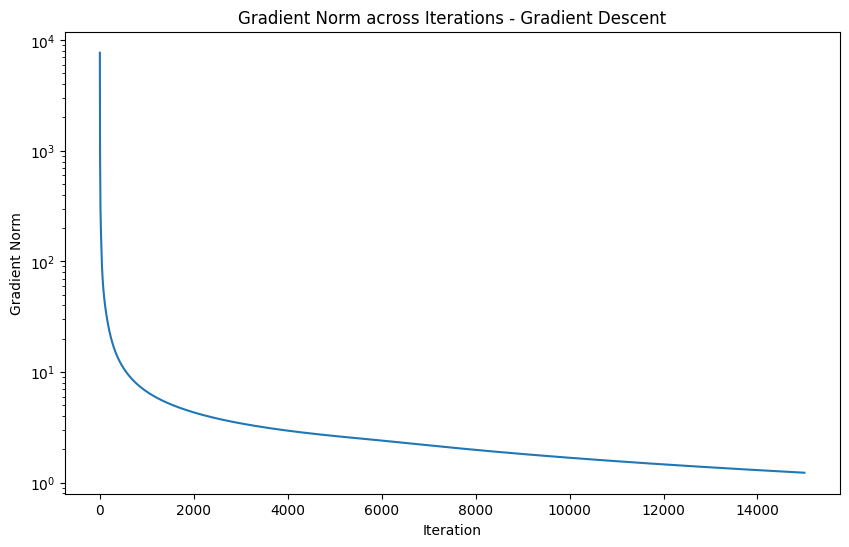

In [129]:
X_values, gradient_norms_GD, times_GD = gradient_descent_final(X,A_train,labels_train, lr= 0.001, cost_function = cost_function_3,  iterations= 15000)


losses_GD = [cost_function_3(X_val, A_train, labels_train) for X_val in X_values]

plotting(times_GD,losses_GD,gradient_norms_GD)

In [143]:
# Check accuracy on the test set, using GD 

# Find labels according to our trained feature matrix X
label_matrix = A_test @ X_values[-1]
labels_predicted = np.argmax(label_matrix, axis=1)

labels_predicted.shape

# Use numpy's comparison operation to get a boolean array
same_values = (labels_predicted == labels_test.flatten())

# Sum up the True values in the boolean array
num_same_values = np.sum(same_values)

accuracy = (num_same_values / labels_test.shape[0]) * 100


print("Accuracy on test is {} %".format(accuracy))






Accuracy on test is 96.08540925266904 %


In [153]:
# Generate the list of random choices of classes beforehand 
random_choices = []
for i in range(15000):# 15000 iterations in BCGD
    random_choices.append(random.randint(0,k-1))



[2, 7, 0, 2, 1, 5, 2, 0, 5, 6, 6, 5, 9, 9, 1, 6, 0, 4, 1, 0, 4, 4, 8, 1, 8, 7, 5, 6, 4, 8, 0, 1, 0, 4, 2, 0, 6, 4, 8, 2, 2, 4, 6, 5, 9, 3, 1, 3, 8, 6, 4, 0, 5, 0, 4, 5, 4, 3, 1, 1, 3, 0, 5, 7, 8, 3, 5, 1, 2, 7, 9, 1, 6, 2, 2, 3, 1, 9, 9, 6, 9, 0, 8, 4, 4, 4, 3, 8, 9, 0, 8, 5, 3, 8, 4, 8, 3, 1, 0, 1, 5, 0, 2, 2, 7, 2, 8, 1, 1, 5, 5, 8, 5, 3, 4, 5, 3, 6, 0, 9, 3, 0, 5, 5, 6, 6, 0, 5, 8, 9, 9, 1, 2, 5, 8, 1, 1, 7, 4, 1, 0, 8, 7, 4, 6, 3, 6, 5, 7, 0, 7, 3, 6, 8, 9, 1, 6, 1, 5, 5, 8, 1, 9, 6, 5, 3, 2, 1, 0, 7, 5, 4, 6, 1, 8, 9, 7, 5, 8, 1, 5, 6, 9, 8, 0, 9, 6, 4, 2, 7, 5, 1, 2, 1, 4, 4, 9, 9, 6, 1, 7, 6, 8, 2, 0, 3, 6, 8, 6, 5, 2, 7, 8, 3, 4, 2, 1, 0, 8, 8, 9, 5, 1, 3, 9, 5, 6, 9, 5, 3, 0, 6, 2, 1, 1, 6, 5, 2, 4, 0, 1, 2, 2, 5, 2, 7, 0, 9, 2, 7, 5, 9, 9, 9, 5, 2, 8, 6, 0, 1, 0, 6, 3, 5, 6, 3, 2, 2, 5, 8, 3, 0, 7, 2, 8, 3, 7, 5, 8, 6, 0, 7, 2, 7, 3, 8, 5, 0, 4, 0, 0, 0, 6, 5, 2, 7, 6, 8, 7, 4, 7, 9, 0, 5, 4, 2, 9, 9, 6, 8, 6, 3, 3, 1, 2, 0, 3, 7, 0, 0, 6, 8, 2, 8, 9, 6, 8, 8, 3, 7, 1, 6, 9, 

In [155]:
m = A_train.shape[0] # set m to training examples , need to put m as param into function
#gradient_descent(X,A_train, label_train,lr = 0.0025, iterations=100)
X_values, gradient_norms_BCGD, times_BCGD = BCGD_randomized(X,A_train, labels_train,lr= 0.001, cost_function= cost_function_3, iterations=15000)
losses_BCGD = [cost_function_3(X_val, A_train, labels_train) for X_val in X_values]

plotting(times_BCGD, losses_BCGD, gradient_norms_BCGD)

2


InvalidIndexError: (slice(None, None, None), 2)